In [1]:
import numpy as np
from functions import newton_eq, plot_error_iter
import matplotlib.pyplot as plt
import cvxpy as cp
from time import time
def cvx_solution(A, b, c):
    m, n = A.shape
    x = cp.Variable(n)
    obj = cp.Minimize(c@x)
    cons = [A@x == b, x >= 0]
    prob = cp.Problem(obj, cons)
    prob.solve(solver="MOSEK")
    return prob.value

def log_barrier(x0, A, b, t, mu, TOL=1e-8, MAXITERS=100,  alpha=0.01, beta=0.8,print_iter=False):
    t = t
    x_inner = x0.copy()
    m, n = A.shape
    nabla_f = lambda x: np.diag(1/x**2)
    dom_f = lambda x: np.all(x>0)
    central_path = []
    while m/t > TOL:
        f = lambda x: t*c.dot(x) - np.sum(np.log(x))
        grad_f = lambda x: t*c - 1/x
        x_list = newton_eq(f, grad_f, nabla_f, x_inner, A, b, dom_f, MAXITERS=MAXITERS, TOL=TOL, alpha=alpha, beta=beta, print_iter=print_iter)
        x_inner = x_list[-1]
        t *= mu
        central_path.append(x_inner)
    return central_path


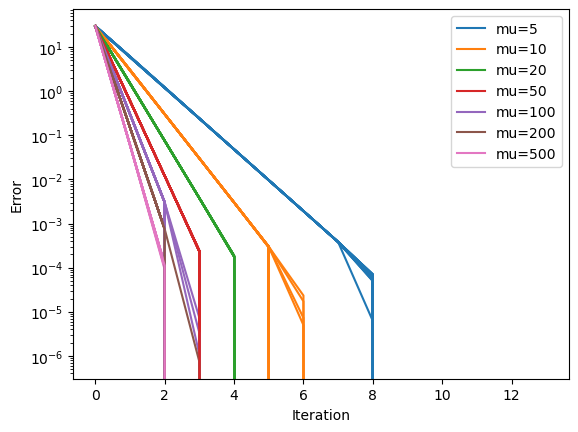

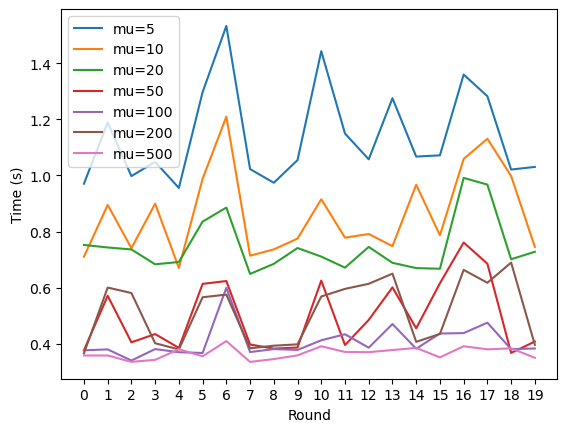

In [6]:
# m: number of constraints
# n: number of variables
import matplotlib
m = 200
n = 500
np.random.seed(0)
rounds=20
mu_list = [5, 10, 20, 50, 100, 200, 500]
# get matplot colors map for mu_list
# colors = matplotlib.colormaps.get_cmap('cool')(np.linspace(0, 1, len(mu_list)))
colors = list(matplotlib.colormaps.get_cmap('tab10').colors[:len(mu_list)])
time_consumed = np.zeros((rounds,len(mu_list)))
iters = 0
while iters < rounds:
    A = np.random.randn(m, n)
    x0 = np.random.random(n)
    b = A.dot(x0)
    z = np.random.randn(m)
    s = 10*np.random.random(n)
    # This is to make sure that the dual problem is feasible in interior since A.T @ z < c.
    c = A.T.dot(z) + s
    sol = cvx_solution(A, b, c)
    for index, mu in enumerate(mu_list):
        start_time = time()
        x_lb = log_barrier(x0.copy(), A, b, t=10, mu=mu, TOL=1e-8, MAXITERS=100,  alpha=0.01, beta=0.8, print_iter=False)
        end_time = time()
        time_consumed[iters, index] = end_time-start_time
        plot_error_iter(x_lb@c, sol, "mu="+str(mu), color=colors[index])
    iters += 1

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend(["mu="+str(mu) for mu in mu_list])
plt.savefig("./figure/log_barrier_%d_%d.png"%(m,n))
plt.show()

for index, mu in enumerate(mu_list):
    plt.plot(time_consumed[:,index], color=colors[index])
plt.xticks(np.arange(0, 20, 1))
plt.xlabel("Round")
plt.ylabel("Time (s)")
plt.legend(["mu="+str(mu) for mu in mu_list])
plt.savefig("./figure/log_barrier_%d_%d_time.png"%(m,n))
plt.show()